In [11]:
from selenium import webdriver
from selenium.webdriver.common.keys import Keys
from bs4 import BeautifulSoup
from konlpy.tag import *
from PIL import Image
from wordcloud import WordCloud
from collections import Counter
from googletrans import Translator

import numpy as np
import matplotlib.pyplot as plt
import chromedriver_autoinstaller
import calendar
import random
import math
import time
import json


#크롬 드라이버로 url 주소 실행
def InitWeb(url = "", isMaximized = False) :
    if isMaximized :
        driver.maximize_window()
        
    driver.get(url)
    driver.implicitly_wait(10)

#return : soup
def GetSoup() :
    html = driver.page_source
    return BeautifulSoup(html, "html.parser")

#xPath 주소창에 key 검색 후 enter
def Search(xPath, key) :
    element = driver.find_element_by_xpath(xPath)
    element.click( )
    element.send_keys(key)
    element.send_keys("\n")
    driver.implicitly_wait(10)

#xPath 순차 클릭
def Click(xPathList) :
    for i in xPathList :
        driver.find_element_by_xpath(i).click()
        time.sleep(random.uniform(0.5, 1))

#cnt(원하는 검색 수)와 cntPerPg(한 페이지당 나오는 수)를 이용해 pgCnt(필요한 페이지 수) 계산
#pgCnt 만큼 END 키
def PageDown(cnt, cntPerPg) :
    pgCnt = math.ceil(cnt / cntPerPg)
    for i in range(0, pgCnt + 3) :
        element = driver.find_element_by_tag_name("body")
        element.send_keys(Keys.END)
        time.sleep(random.uniform(1, 1.2))

#json 형태로 저장/불러오기
#저장위치, 이름, 저장할 데이터, 저장/불러오기
def SaveLoad(name, data = None, w = False) :
    fullPath = "%s/%s.txt" %(basePath, name)
    if w :
        with open(fullPath, "w", encoding = "utf-8") as f :
            f.write(json.dumps(data, ensure_ascii=False, indent=4))
            f.close()
    else :
        with open(fullPath, "r", encoding = "utf-8") as f :
            data = json.load(f)
            f.close()
            return data

#======================================

#네이버 날짜 검색
def SetNaverDate(yyyymmdd) :
    date = yyyymmdd.split("-")
    basePath = '//*[@id="snb"]/div[2]/ul/li[3]/div/div[2]/div[2]/div[YMD]/div/div/div/ul/li[NUM]/a'
    
    yearPath = basePath.replace("YMD", "1").replace("NUM", str(int(date[0])-2002))
    monthPath = basePath.replace("YMD", "2").replace("NUM", date[1])
    datePath = basePath.replace("YMD", "3").replace("NUM", date[2])
    
    xPathList.append(yearPath)
    xPathList.append(monthPath)
    xPathList.append(datePath)

#네이버 날짜 월별 1~말일 검색후 마지막 페이지까지
def SearchNaverByMonth(year, month) :
    startDate = "%s-%s-%s" %(year, month, "1")
    endDate = "%s-%s-%s" %(year, month, calendar.monthrange(year, month)[1])
    
    xPathList.clear()
    xPathList.append('//*[@id="snb"]/div[2]/ul/li[3]/div/div[1]/a[9]')
    SetNaverDate(startDate)
    xPathList.append('//*[@id="snb"]/div[2]/ul/li[3]/div/div[2]/div[1]/span[3]/a')
    SetNaverDate(endDate)
    xPathList.append('//*[@id="snb"]/div[2]/ul/li[3]/div/div[2]/div[3]/button')
    Click(xPathList)
    
    PageDown(1000, 30)
    contents = GetSoup().find("ul", "lst_total").find_all("a", "api_txt_lines total_tit")
    
    if len(contents) == 1000 :
        return contents
    else :
        PageDown(1000 - len(contents), 30)
        return contents
    
#한글명사 추출
def GetNouns(container, data) :
    for i in data :
        nouns = kkma.nouns(i.get_text().strip())
        for j in nouns :
            container.append(j)

In [12]:
#크롬 드라이버
chromedriver_autoinstaller.install()
options = webdriver.ChromeOptions()
driver = webdriver.Chrome(options=options)

#변수
kkma = Kkma()

naverDict = dict()
naverWordDict = dict()

xPathList = list()
koreanCityList = list()
countryList = list()
popularCityList = list()
popularCityKoList = list()

basePath = "C:/py_temp/temp"

In [44]:
#네이버 블로그
InitWeb("https://www.naver.com/", True)
Search('//*[@id="query"]', "여행")
    
xPathList.clear()
xPathList.append('//*[@id="lnb"]/div[1]/div/ul/li[5]/a')
xPathList.append('//*[@id="snb"]/div[1]/div/div[1]/a[2]')
xPathList.append('//*[@id="snb"]/div[1]/div/div[2]/a')

Click(xPathList)

for i in (2019, 2020) :
    naverDict[i] = []
    for j in range(1, 13) :
        titles = SearchNaverByMonth(i, j)
        GetNouns(naverDict[i], titles)

SaveLoad("naver", naverDict, True)
naverDict = SaveLoad("naver")

#======================================
print("2019 :")
print(Counter(naverDict["2019"]).most_common(10))
print("\n2020 :")
print(Counter(naverDict["2020"]).most_common(10))
#======================================

2019 :
[('여행', 11652), ('일', 1377), ('박', 1222), ('자유', 1207), ('코스', 1197), ('자유여행', 1018), ('제주', 909), ('추천', 900), ('2', 883), ('3', 837)]

2020 :
[('여행', 11702), ('제주', 1669), ('도', 1522), ('코스', 1198), ('곳', 1111), ('일', 931), ('2', 869), ('박', 820), ('1', 806), ('제주도', 761)]


In [154]:
#대한민국 도시 목록
InitWeb("https://ko.wikipedia.org/wiki/대한민국의_인구순_도시_목록")
time.sleep(0.5)
data = GetSoup().find("table", "wikitable sortable jquery-tablesorter").find_all("a")

for i in data :
    txt = i.get_text().rstrip("시").rstrip("군")
    txt = txt.replace("남도", "").replace("북도", "")
    
    if txt.find("특별") != -1 :
        txt = txt.split("특별")
        txt = txt[0]
    elif txt.find("광역") != -1 :
        txt = txt.split("광역")
        txt = txt[0]
        
    if txt == "경기도" : txt = "경기"
    if txt == "강원도" : txt = "강원"
    
    koreanCityList.append(txt)

koreanCityList = list(set(koreanCityList))

SaveLoad("koreanCity", koreanCityList, True)
koreanCityList = SaveLoad("koreanCity")

#======================================
koreanCityList
#======================================

['보은',
 '장흥',
 '영덕',
 '경기',
 '완주',
 '함안',
 '서산',
 '영동',
 '대구',
 '김해',
 '서귀포',
 '순창',
 '춘천',
 '천안',
 '충청',
 '금산',
 '수원',
 '김제',
 '진도',
 '청송',
 '여주',
 '강릉',
 '진주',
 '울릉',
 '용인',
 '서천',
 '함평',
 '의령',
 '서울',
 '세종',
 '가평',
 '영광',
 '청양',
 '경상',
 '화천',
 '해남',
 '계룡',
 '당진',
 '안양',
 '장성',
 '영양',
 '남양주',
 '정선',
 '무안',
 '거제',
 '목포',
 '화순',
 '하동',
 '홍성',
 '구미',
 '이천',
 '증평',
 '경주',
 '고양',
 '동두천',
 '부천',
 '신안',
 '아산',
 '창원',
 '담양',
 '산청',
 '예천',
 '의왕',
 '철원',
 '문경',
 '의정부',
 '양주',
 '진천',
 '구례',
 '포천',
 '홍천',
 '연천',
 '고성',
 '원주',
 '밀양',
 '광양',
 '안산',
 '구리',
 '논산',
 '봉화',
 '고창',
 '무주',
 '고흥',
 '부여',
 '사천',
 '울진',
 '경산',
 '횡성',
 '평택',
 '남원',
 '김포',
 '영주',
 '완도',
 '성남',
 '태안',
 '익산',
 '공주',
 '청도',
 '함양',
 '속초',
 '전주',
 '음성',
 '시흥',
 '군위',
 '전라',
 '동해',
 '남해',
 '칠곡',
 '곡성',
 '안동',
 '제천',
 '김천',
 '양산',
 '청주',
 '제주',
 '순천',
 '삼척',
 '인제',
 '부산',
 '광명',
 '양구',
 '창녕',
 '군포',
 '파주',
 '정읍',
 '여수',
 '과천',
 '옥천',
 '영월',
 '양양',
 '장수',
 '합천',
 '광주',
 '진안',
 '상주',
 '나주',
 '거창',
 '의성',
 '울산',
 '예산',
 '보성',
 '오산',
 '

In [190]:
#나라 목록
InitWeb("https://ko.wikipedia.org/wiki/나라_목록")
time.sleep(0.5)
data = GetSoup().find("div", "mw-body-content mw-content-ltr").find_all("b")

for i in data :
    txt = i.get_text()
    if txt.find(" ") == 0 :
        txt = txt.lstrip(" ")
        countryList.append(txt)
        
countryList = list(set(countryList))

SaveLoad("country", countryList, True)
countryList = SaveLoad("country")

#======================================
countryList
#======================================

['엘살바도르',
 '베네수엘라',
 '앤티가 바부다',
 '볼리비아',
 '코모로',
 '요르단',
 '통가',
 '튀니지',
 '과테말라',
 '미국',
 '에콰도르',
 '중국',
 '세인트루시아',
 '모로코',
 '몬테네그로',
 '토고',
 '불가리아',
 '바베이도스',
 '부룬디',
 '바레인',
 '라이베리아',
 '루마니아',
 '사우디아라비아',
 '아랍에미리트',
 '차드',
 '코스타리카',
 '싱가포르',
 '키프로스',
 '나이지리아',
 '니우에',
 '알제리',
 '베트남',
 '헝가리',
 '벨기에',
 '벨라루스',
 '조지아',
 '우즈베키스탄',
 '마셜 제도',
 '콩고',
 '말라위',
 '타이완',
 '말리',
 '가봉',
 '리비아',
 '이스라엘',
 '스리랑카',
 '슬로바키아',
 '파나마',
 '아르헨티나',
 '폴란드',
 '서사하라',
 '몽골',
 '코소보',
 '아일랜드',
 '일본',
 '압하지야',
 '스위스',
 '베냉',
 '핀란드',
 '룩셈부르크',
 '자메이카',
 '사모아',
 '가나',
 '수단',
 '아르차흐',
 '세인트키츠 네비스',
 '온두라스',
 '리히텐슈타인',
 '체코',
 '브루나이',
 '카보베르데',
 '잠비아',
 '카메룬',
 '트란스니스트리아',
 '러시아',
 '세르비아',
 '조선민주주의인민공화국',
 '짐바브웨',
 '알바니아',
 '피지',
 '슬로베니아',
 '감비아',
 '아르메니아',
 '남수단',
 '지부티',
 '말레이시아',
 '소말리아',
 '세이셸',
 '바누아투',
 '키르기스스탄',
 '포르투갈',
 '영국',
 '르완다',
 '터키',
 '적도 기니',
 '투발루',
 '오스트레일리아',
 '레소토',
 '남아공',
 '기니비사우',
 '태국',
 '앙골라',
 '키리바시',
 '크로아티아',
 '중앙아프리카 공화국',
 '북키프로스',
 '니카라과',
 '투르크메니스탄',
 '쿠웨이트',
 '인도네시아',
 '멕시코',
 '세인트빈센

In [15]:
#유명 도시 목록(영)
InitWeb("https://www.visualcapitalist.com/the-100-most-popular-city-destinations/")
time.sleep(0.5)
driver.find_element_by_xpath("//select[@name='tablepress-1056_length']/option[text()='100']").click()
data = GetSoup().find("table", "tablepress tablepress-id-1056 dataTable no-footer").find_all("tr")

for i in data :
    contents = i.find_all("td")
    if (len(contents) != 0) :
        city = contents[1].get_text()
        popularCityList.append(city)

popularCityList = list(set(popularCityList))

SaveLoad("popularCity", popularCityList, True)
popularCityList = SaveLoad("popularCity")

#======================================
popularCityList
#======================================

['Kolkatta',
 'Florence',
 'London',
 'Osaka',
 'Jerusalem',
 'Ha Noi',
 'Barcelona',
 'Shenzhen',
 'Orlando',
 'Fukuoka',
 'Mecca',
 'Agra',
 'Warsaw',
 'Amsterdam',
 'Bangkok',
 'Chiang Mai',
 'Tokyo',
 'Venice',
 'Johannesburg',
 'Munich',
 'Madrid',
 'Delhi',
 'Guangzhou',
 'Medina',
 'Cairo',
 'Abu Dhabi',
 'Johor Bahru',
 'Miami',
 'Moscow',
 'Bangalore',
 'Singapore',
 'Dammam',
 'Honolulu',
 'Jakarta',
 'Chiba',
 'Zhuhai',
 'Macau',
 'Marrakech',
 'Auckland',
 'Milan',
 'Heraklion',
 'Cebu',
 'Denpasar',
 'Da Nang',
 'Lima',
 'Buenos Aires City',
 'Porto',
 'Batam',
 'Seoul',
 'Rio de Janeiro',
 'Cancun',
 'Vienna',
 'Brussels',
 'Athens',
 'Las Vegas',
 'Jeju',
 'Shanghai',
 'Kyoto',
 'Kuala Lumpur',
 'Rhodes',
 'Taipei',
 'Stockholm',
 'Nice',
 'Hong Kong',
 'Ho Chi Minh City',
 'San Francisco',
 'Ha Long',
 'Riyadh',
 'Frankfurt',
 'Istanbul',
 'Tel Aviv',
 'Melbourne',
 'Beijing',
 'Krabi',
 'Mumbai',
 'Berlin',
 'Toronto',
 'Rome',
 'Prague',
 'St. Petersburg',
 'Mugla',
 

In [55]:
#유명 도시 목록(한)
tempList = list()

for i in popularCityList :
    translator = Translator()
    result = translator.translate(i, src="en", dest="ko")
    tempList.append(result.text)

for i in tempList :
    city = i.replace(" ", "").rstrip("도시")
    
    if city == "JohorBahru." : city = "조호르바루"
    elif city == "Zhuhai." : city = "주하이"
    elif city == "heraklion." : city = "헤라클리온"
    elif city == "무덤" : city = "물라"
    elif city == "심천" : city = "선전"
    elif city == "올랜" : city = "올랜도"
    elif city == "계곡" : city = "구이린"
    elif city == "서울" : continue
    elif city == "제주" : continue
    
    popularCityKoList.append(city)

SaveLoad("popularCityKo2", popularCityKoList, True)
popularCityKoList = SaveLoad("popularCityKo2")

#======================================
popularCityKoList
#======================================

['콜카타',
 '피렌체',
 '런던',
 '오사카',
 '예루살렘',
 '하노이',
 '바르셀로나',
 '선전',
 '올랜도',
 '후쿠오카',
 '메카',
 '아그라',
 '바르샤바',
 '암스테르담',
 '방콕',
 '치앙마이',
 '도쿄',
 '베니스',
 '요하네스버그',
 '뮌헨',
 '마드리드',
 '델리',
 '광저우',
 '메디나',
 '카이로',
 '아부다비',
 '조호르바루',
 '마이애미',
 '모스크바',
 '방갈로르',
 '싱가포르',
 '다가미네이션',
 '호놀룰루',
 '자카르타',
 '치바',
 '주하이',
 '마카오',
 '마라케',
 '오클랜드',
 '밀라노',
 '헤라클리온',
 '세부',
 '덴파사르',
 '다낭',
 '리마',
 '부에노스아이레스',
 '포르토',
 '바탐',
 '리오데자네이로',
 '칸쿤',
 '비엔나',
 '브뤼셀',
 '아테네',
 '라스베가스',
 '상하이',
 '교토',
 '쿠알라룸푸르',
 '로도스',
 '타이페이',
 '스톡홀름',
 '좋은',
 '홍콩',
 '호치민',
 '샌프란시스코',
 '하자',
 '리야드',
 '프랑크푸르트',
 '이스탄불',
 '텔아비브',
 '멜버른',
 '베이징',
 '크라비',
 '뭄바이',
 '베를린',
 '토론토',
 '로마',
 '프라하',
 '세인트피터스버그',
 '물라',
 '뉴욕',
 '첸나이',
 '구이린',
 '두바이',
 '파리',
 '후가다',
 '크라코프',
 '부다페스트',
 '더블린',
 '파타야',
 '페낭섬',
 '자이푸르',
 '안탈야의',
 '리스본',
 '코펜하겐',
 '시드니',
 '밴쿠버',
 '푸켓',
 '로스앤젤레스']

In [13]:
#=================================================여기서부터
naverDict = SaveLoad("naver")
koreanCityList = SaveLoad("koreanCity")
countryList = SaveLoad("country")
popularCityKoList = SaveLoad("popularCityKo2")

In [15]:
#나라 및 도시 색출
def FindPlaces(data) :
    placeList = list()
    
    for i in data :
        if any(chr.isdigit() for chr in i) : continue
        elif len(i) == 1 : continue

        for j in countryList :
            if i.find(j) != -1 :
                placeList.append(j)
                break

        for j in popularCityList :
            if i.find(j) != -1 :
                placeList.append(j)
                break

        for j in koreanCityList :
            if i.find(j) != -1 :
                placeList.append(j)
                break
                
    return placeList

for i in ("2019", "2020") :
    naverWordDict[i] = Counter(FindPlaces(naverDict[i]))
    name = "naver%s" %i
    SaveLoad(name, naverWordDict[i], True)

#======================================
print("2019 :")
print(naverWordDict["2019"].most_common(10))
print("\n2020 :")
print(naverWordDict["2020"].most_common(10))
#======================================

2019 :
[('제주', 1693), ('일본', 455), ('부산', 415), ('강원', 399), ('베트남', 326), ('스페인', 254), ('중국', 247), ('이탈리아', 229), ('강릉', 218), ('미국', 212)]

2020 :
[('제주', 3045), ('강원', 747), ('부산', 470), ('강릉', 431), ('서울', 333), ('경주', 327), ('여수', 299), ('속초', 285), ('거제', 262), ('남해', 194)]


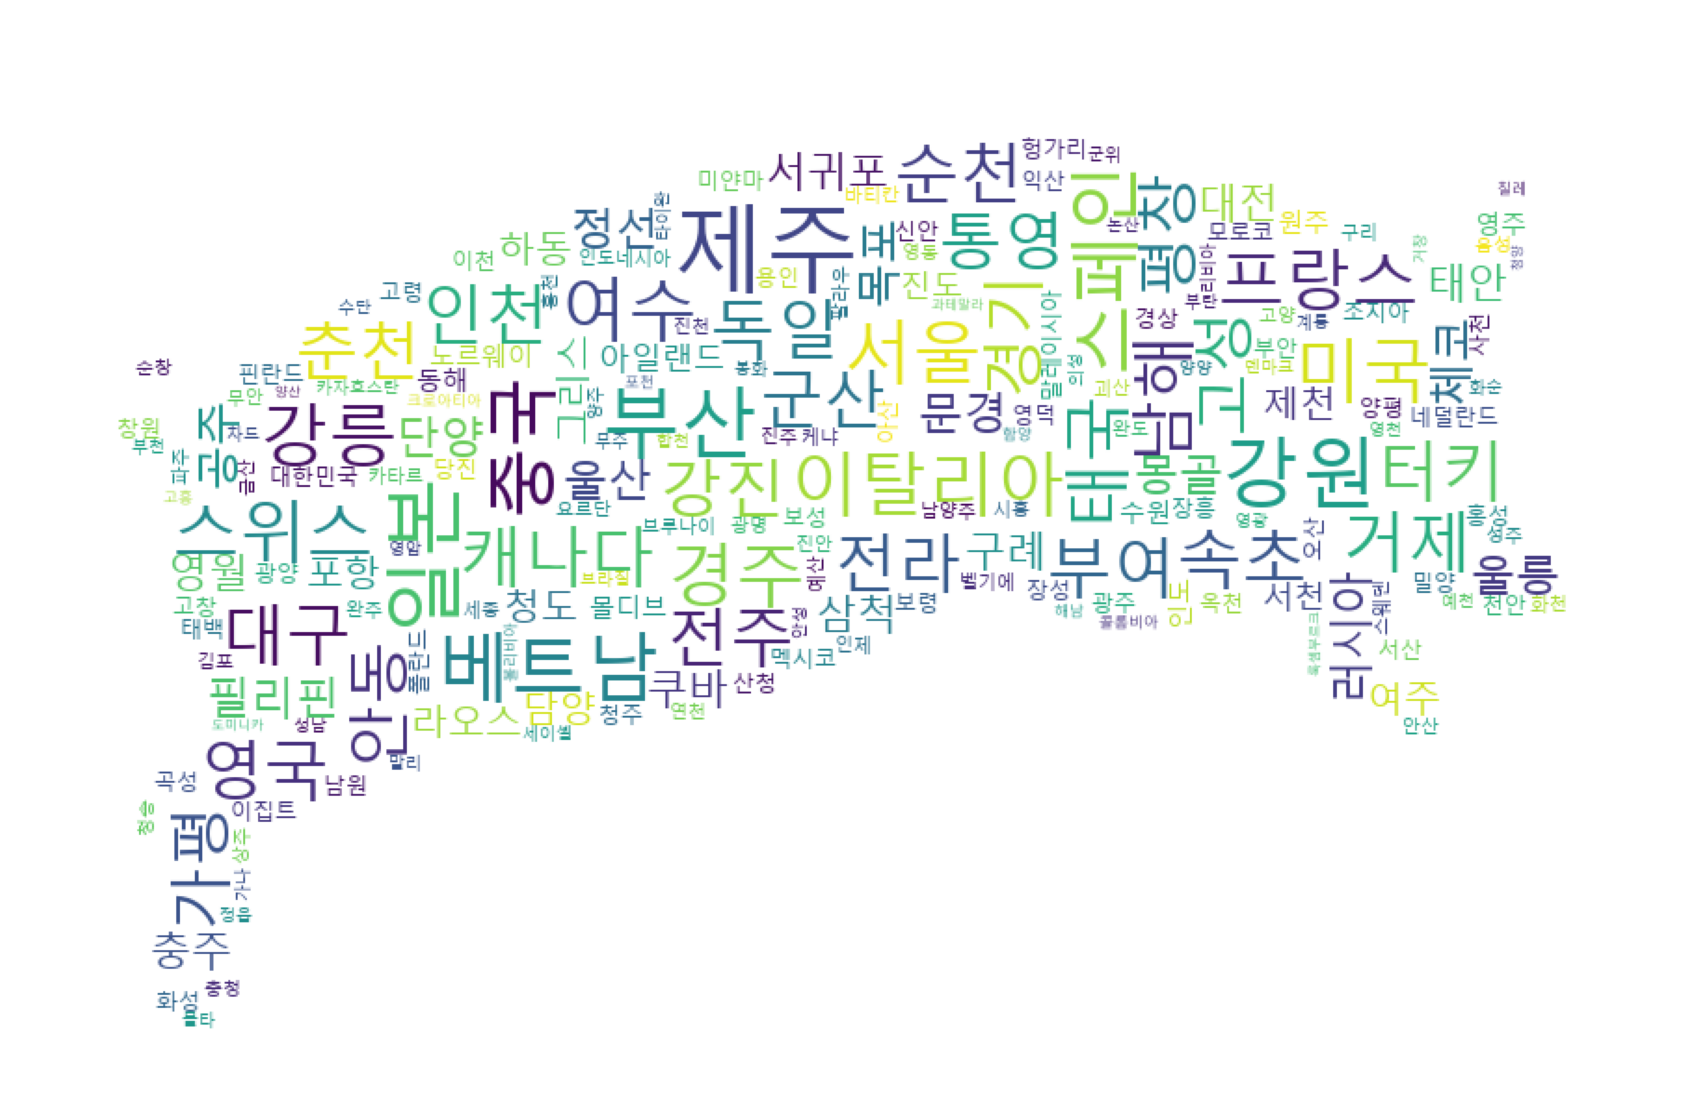

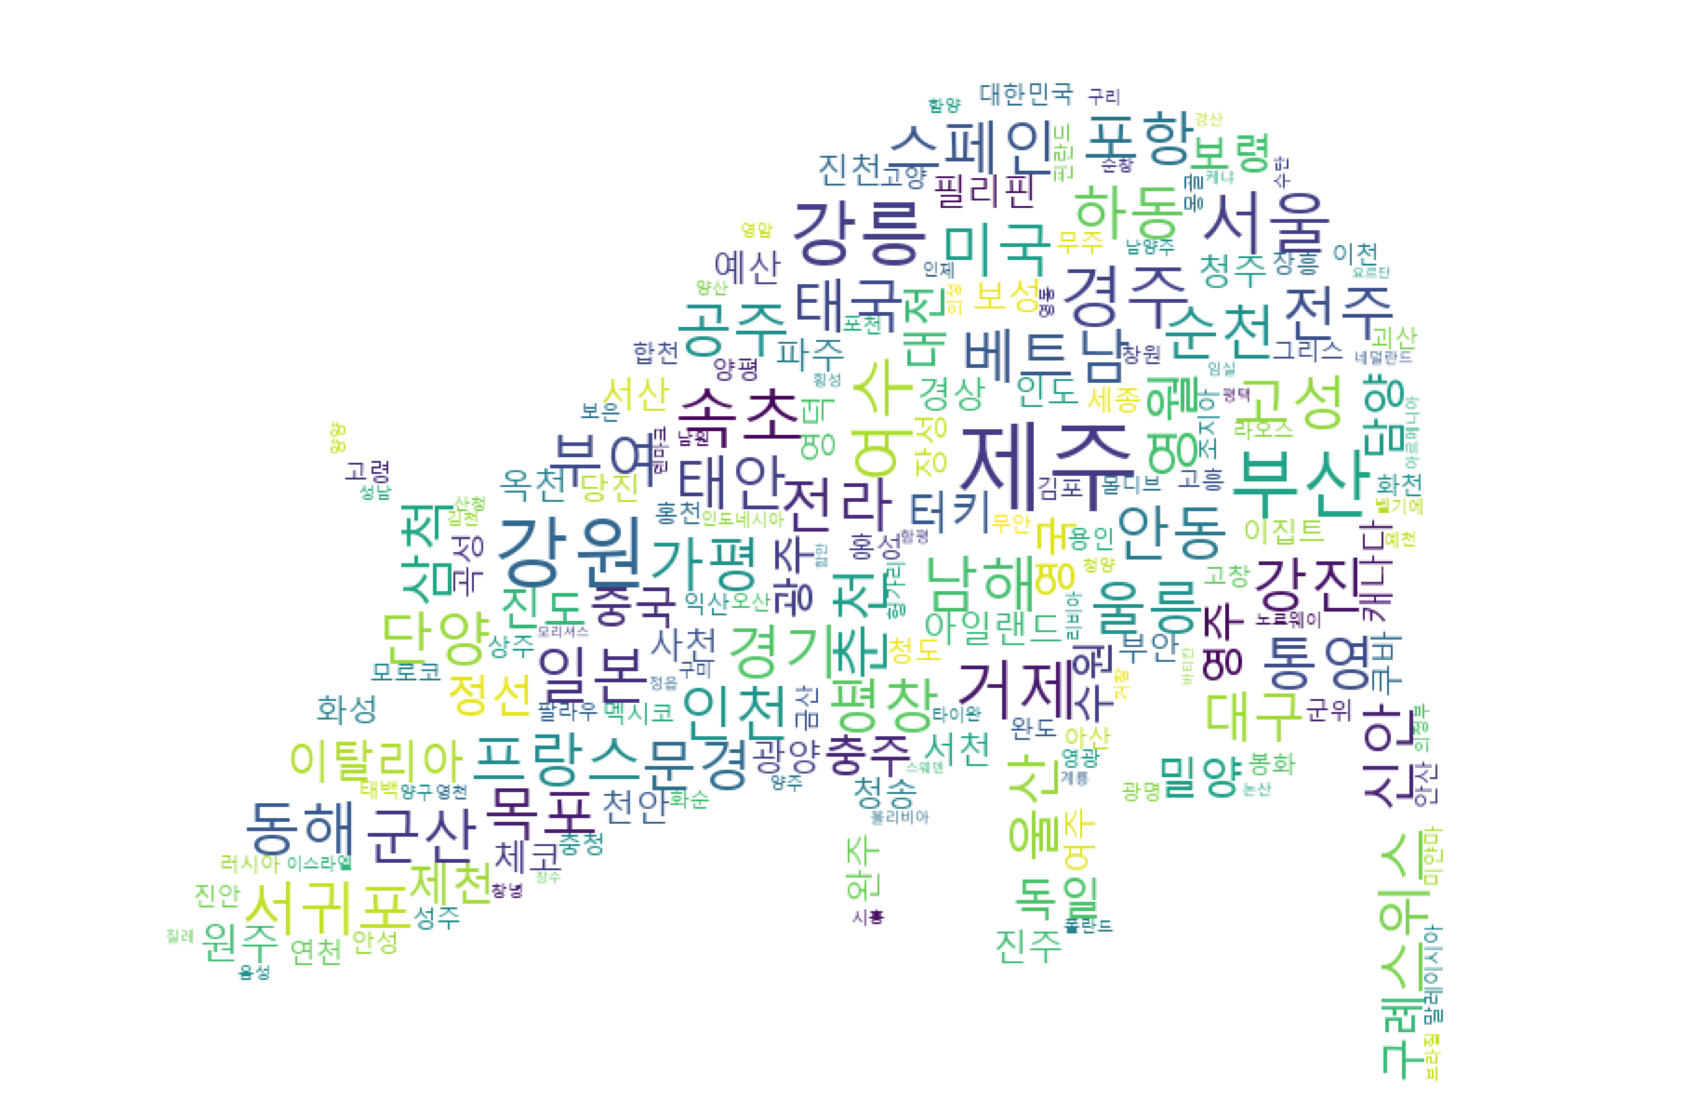

In [16]:
#naver 2019, 2020 워드 클라우드
for i in naverWordDict.keys() :
    imgPath = "C:/py_temp/temp/%s.png" %i
    img = np.array(Image.open(imgPath))

    data = dict(naverWordDict[i].most_common(200))
    wordCloud = WordCloud(font_path="C:\py_temp\malgun.ttf", 
                          relative_scaling=0.2,
                          mask=img,
                          background_color="white",
                          min_font_size=1,
                          max_font_size=50,
                          max_words=500
                         ).generate_from_frequencies(data)

    plt.figure(figsize=(30,20))
    plt.imshow(wordCloud)
    plt.axis("off")
    plt.show()